In [8]:
##Imports
%matplotlib inline
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json
## This is to get the connection to the nba endpoints correctly (hot fix to work until they push changes)
headers = {
    'Host': 'stats.nba.com',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:61.0) Gecko/20100101 Firefox/61.0',
    'Accept': 'application/json, text/plain, */*',
    'Accept-Language': 'en-US,en;q=0.5',
    'Referer': 'https://stats.nba.com/',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive',
}

In [136]:
from nba_api.stats.endpoints import playergamelog
## Lebron James
pgl = playergamelog.PlayerGameLog(player_id=2544, headers=headers)
gamelog = pgl.get_data_frames()[0]
gamelog.head()

,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22019,2544,0021900390,"DEC 15, 2019",LAL @ ATL,None,37,12,20,0.600,...,10,11,7,1,3,4,1,31,9,0
1,22019,2544,0021900374,"DEC 13, 2019",LAL @ MIA,W,37,11,22,0.500,...,7,9,12,1,0,8,2,28,9,1
2,22019,2544,0021900358,"DEC 11, 2019",LAL @ ORL,W,38,11,24,0.458,...,9,11,10,2,0,6,2,25,8,1
3,22019,2544,0021900342,"DEC 08, 2019",LAL vs. MIN,W,28,12,20,0.600,...,3,4,13,1,0,5,4,32,24,1
4,22019,2544,0021900329,"DEC 06, 2019",LAL @ POR,W,34,11,23,0.478,...,6,7,8,0,1,3,1,31,21,1


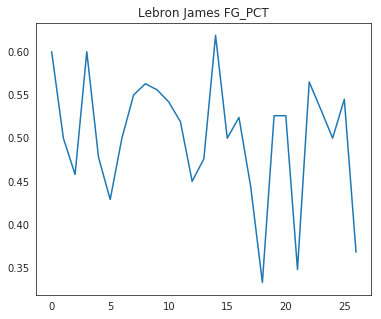

In [137]:
sns.set_style("white")
sns.set_color_codes()
plt.figure(figsize=(6,5))
plt.title('Lebron James FG_PCT')
plt.plot(range(gamelog.shape[0]), gamelog.FG_PCT)
plt.show()

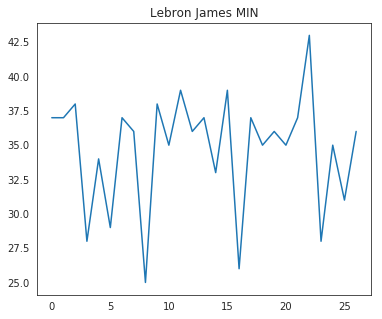

In [138]:
sns.set_style("white")
sns.set_color_codes()
plt.figure(figsize=(6,5))
plt.title('Lebron James MIN')
plt.plot(range(gamelog.shape[0]), gamelog.MIN)
plt.show()

In [139]:
### This is IDEA #2
### TODO: Experiment with different methods to get metrics
### TODO: Construct this as a class so we can call these methods on a player object DESIGN LOLOLOL :/

def determine_stats_win_index(player_game_data):  
    FG_PCT_THRESHOLD = 0.5
    
    stats_win_index = player_game_data.PTS + (2 * player_game_data.AST) 
    + (1.5 * player_game_data.REB) - 2 * (player_game_data.TOV + player_game_data.PF)
    + 2 * (player_game_data.STL + player_game_data.BLK)
    
    return stats_win_index

def plot_stats_to_winning(player_game_data, player_name):
    swi = determine_stats_win_index(player_game_data)
    plt.scatter(swi, player_game_data.PLUS_MINUS, s=300, c=player_game_data.FG_PCT)
    plt.title(player_name + ". His score is: " + str(determine_player_winning_score(player_game_data)))
    plt.show()

In [166]:
def determine_player_winning_score(player_game_data):
    swi = determine_stats_win_index(player_game_data)
    try:
        return np.round(np.mean(player_game_data.PLUS_MINUS.values * swi.values * player_game_data.MIN.values / 48),2)
    except ZeroDivisionError:
        return 0.01

def rank_player_winning_scores(team, efficiencies, n):
    top_n_players = sorted(efficiencies.keys(), reverse=True)
    print(top_n_players)
    print("Top " + str(n) + " players on the " + team)
    for i in range(n):
        print(str(i) + ". " + efficiencies[top_n_players[i]] + " has a stat win index score of: " + str(top_n_players[i]))

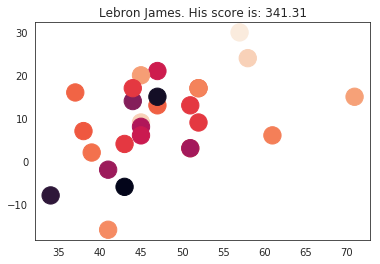

In [168]:
plot_stats_to_winning(gamelog, 'Lebron James')

In [169]:
## Build the team name to team_id map
from nba_api.stats.static import teams
nba_teams = teams.get_teams()
list_teams = ['ATL', 'BOS', 'CLE', 'NOP', 'CHI', 'DAL', 'DEN', 'GSW', 'HOU', 'LAC', 'LAL'
        , 'MIA', 'MIL', 'MIN', 'BKN', 'NYK', 'ORL', 'IND', 'PHI', 'PHX', 'POR', 'SAC'
        , 'SAS', 'OKC', 'TOR', 'UTA', 'MEM', 'WAS', 'DET', 'CHA']
i = 0
team_to_id = {}
for t in list_teams:
    team_to_id.update({t: nba_teams[i]['id']})
    i += 1
print(team_to_id)

{'ATL': 1610612737, 'BOS': 1610612738, 'CLE': 1610612739, 'NOP': 1610612740, 'CHI': 1610612741, 'DAL': 1610612742, 'DEN': 1610612743, 'GSW': 1610612744, 'HOU': 1610612745, 'LAC': 1610612746, 'LAL': 1610612747, 'MIA': 1610612748, 'MIL': 1610612749, 'MIN': 1610612750, 'BKN': 1610612751, 'NYK': 1610612752, 'ORL': 1610612753, 'IND': 1610612754, 'PHI': 1610612755, 'PHX': 1610612756, 'POR': 1610612757, 'SAC': 1610612758, 'SAS': 1610612759, 'OKC': 1610612760, 'TOR': 1610612761, 'UTA': 1610612762, 'MEM': 1610612763, 'WAS': 1610612764, 'DET': 1610612765, 'CHA': 1610612766}


In [181]:
# Make API Call for players across all seasons for a particular franchise
from nba_api.stats.endpoints import franchiseplayers

def get_winning_stats_per_team(team):
    fp = franchiseplayers.FranchisePlayers(team_id=team_to_id[team], headers=headers)
    PLAYERS = fp.get_data_frames()[0]
    # Build the list of players in the 2019-2020 season
    active_players = PLAYERS.loc[PLAYERS['ACTIVE_WITH_TEAM'] == 1]
    ids_per_team = active_players['PERSON_ID'].values
    player_names = active_players['PLAYER'].values
    print(player_names)
    players_per_team = dict(zip(ids_per_team, player_names))
    effectiveness = []
    players = []
    ## Get the winning_stats_for a player
    for player in players_per_team:
        pgl = playergamelog.PlayerGameLog(player_id=player, headers=headers)
        player_game_data = pgl.get_data_frames()[0]
        effectiveness.append(determine_player_winning_score(player_game_data))
        players.append(players_per_team[player])
        plot_stats_to_winning(player_game_data, players_per_team[player])
        
    effect = dict(zip(effectiveness, players)) 
    rank_player_winning_scores(team, effect, 5)

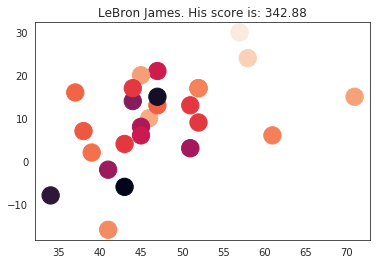

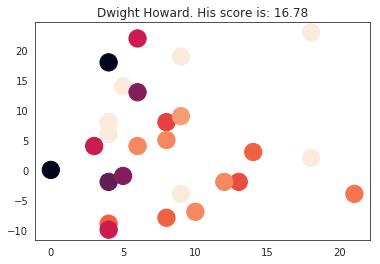

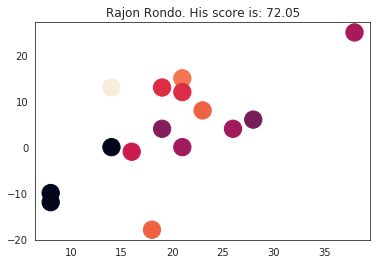

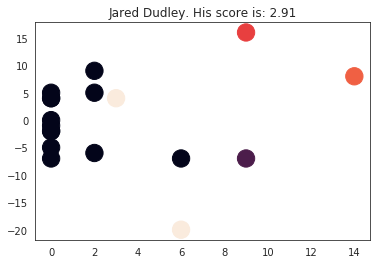

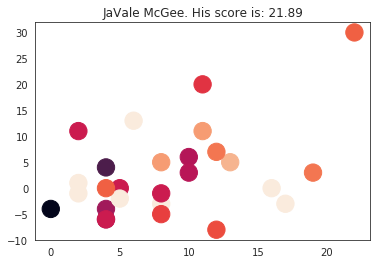

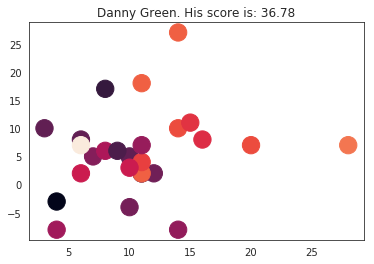

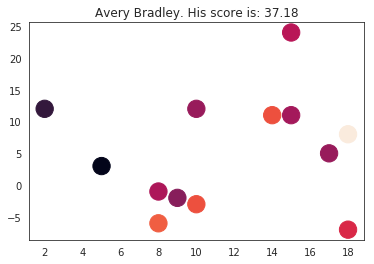

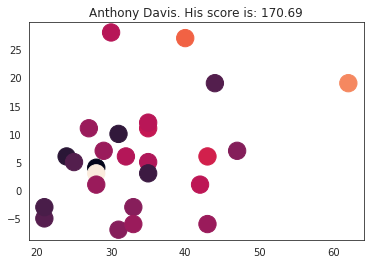

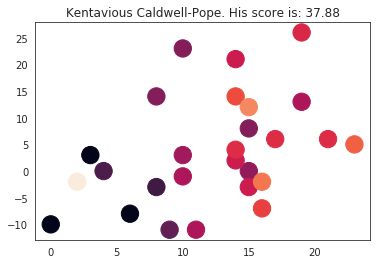

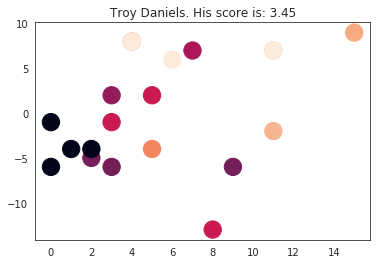

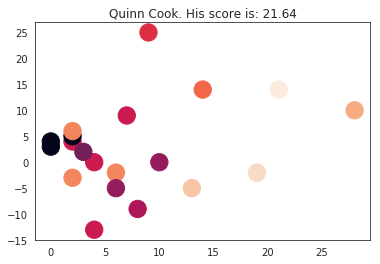

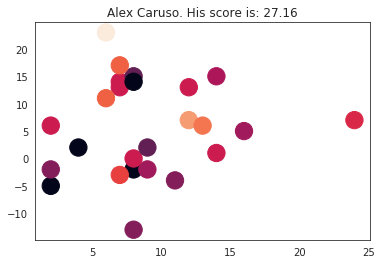

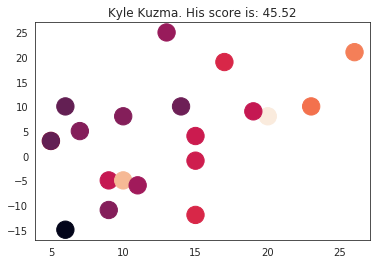

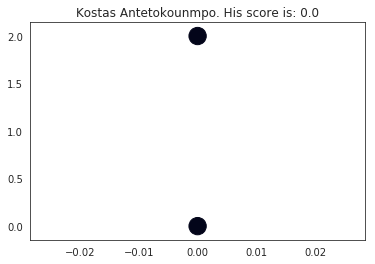

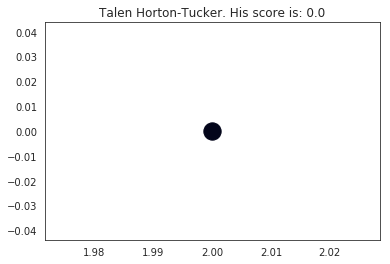

[342.88, 170.69, 72.05, 45.52, 37.88, 37.18, 36.78, 27.16, 21.89, 21.64, 16.78, 3.45, 2.91, 0.0]
Top 5 players on the LAL
0. LeBron James has a stat win index score of: 342.88
1. Anthony Davis has a stat win index score of: 170.69
2. Rajon Rondo has a stat win index score of: 72.05
3. Kyle Kuzma has a stat win index score of: 45.52
4. Kentavious Caldwell-Pope has a stat win index score of: 37.88


In [171]:
get_winning_stats_per_team("LAL")

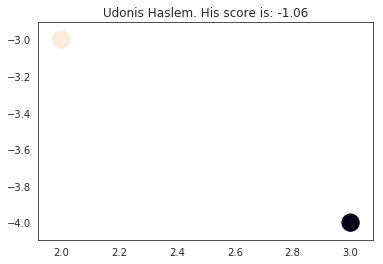

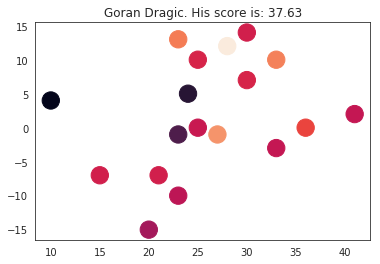

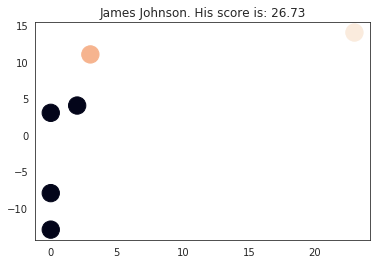

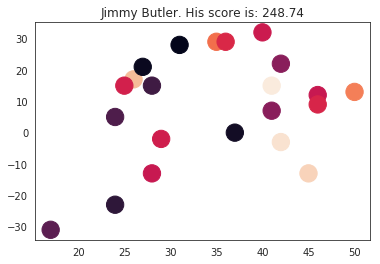

/home/vishnu/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


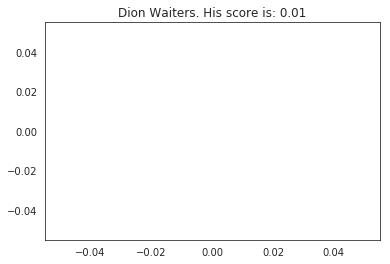

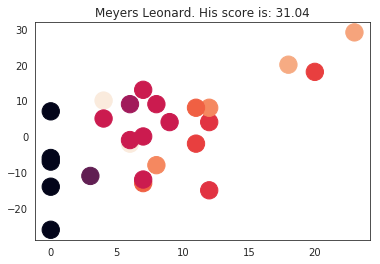

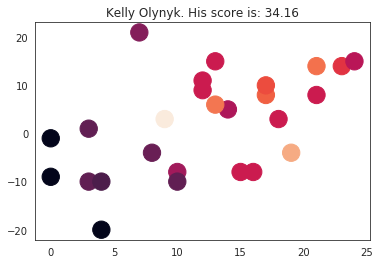

[248.74, 37.63, 34.16, 31.04, 26.73, 0.01, -1.06]
Top 5 players on the MIA
0. Jimmy Butler has a stat win index score of: 248.74
1. Goran Dragic has a stat win index score of: 37.63
2. Kelly Olynyk has a stat win index score of: 34.16
3. Meyers Leonard has a stat win index score of: 31.04
4. James Johnson has a stat win index score of: 26.73


In [172]:
get_winning_stats_per_team("MIA")

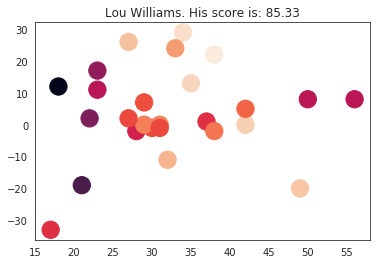

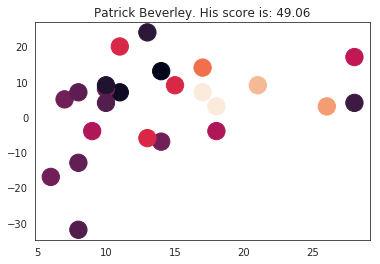

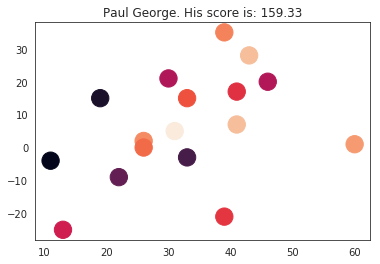

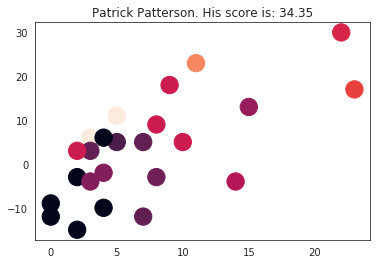

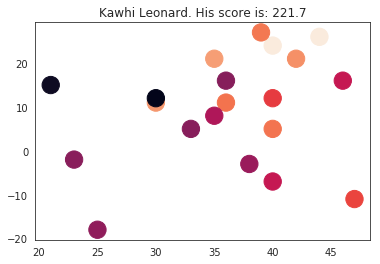

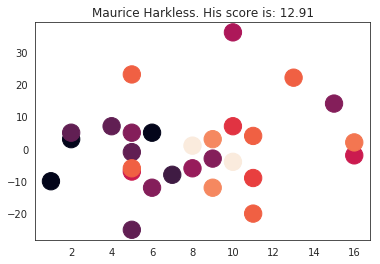

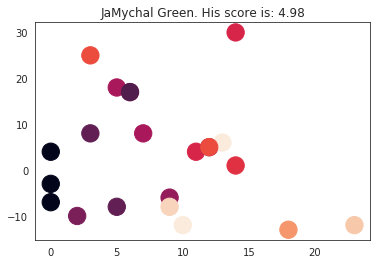

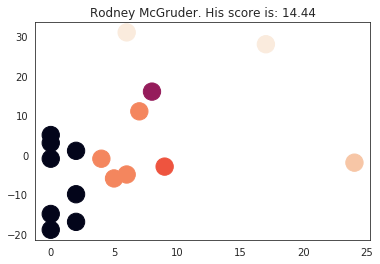

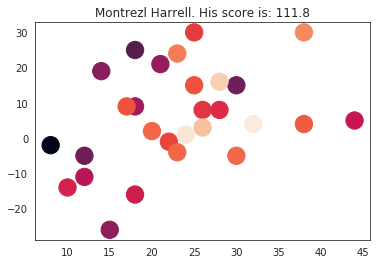

[221.7, 159.33, 111.8, 85.33, 49.06, 34.35, 14.44, 12.91, 4.98]
Top 5 players on the LAC
0. Kawhi Leonard has a stat win index score of: 221.7
1. Paul George has a stat win index score of: 159.33
2. Montrezl Harrell has a stat win index score of: 111.8
3. Lou Williams has a stat win index score of: 85.33
4. Patrick Beverley has a stat win index score of: 49.06


In [174]:
get_winning_stats_per_team("LAC")

['Mike Conley' 'Jeff Green' 'Ed Davis' 'Bojan Bogdanovic' 'Rudy Gobert'
 'Dante Exum' 'Joe Ingles' 'Emmanuel Mudiay']


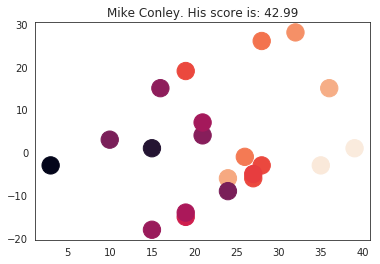

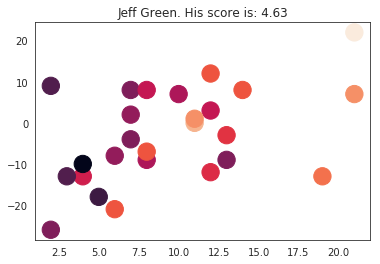

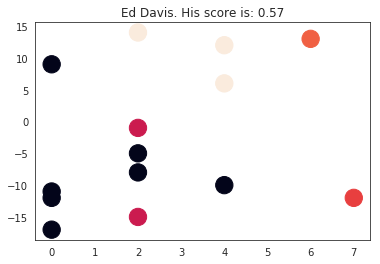

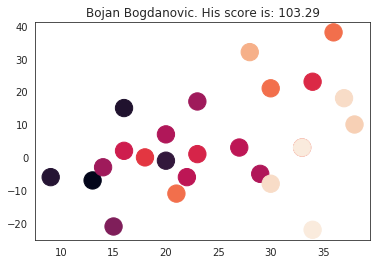

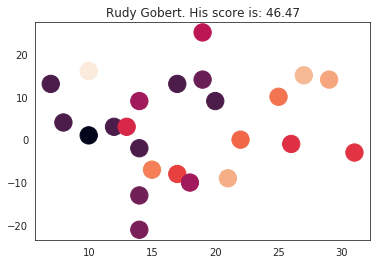

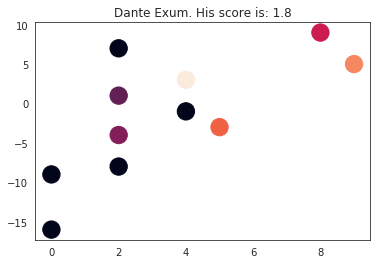

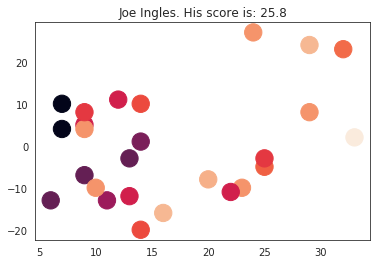

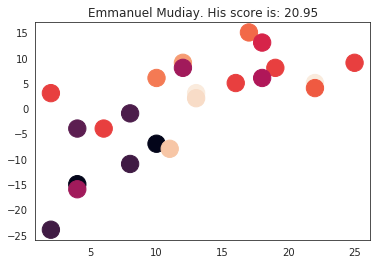

[103.29, 46.47, 42.99, 25.8, 20.95, 4.63, 1.8, 0.57]
Top 5 players on the UTA
0. Bojan Bogdanovic has a stat win index score of: 103.29
1. Rudy Gobert has a stat win index score of: 46.47
2. Mike Conley has a stat win index score of: 42.99
3. Joe Ingles has a stat win index score of: 25.8
4. Emmanuel Mudiay has a stat win index score of: 20.95


In [177]:
get_winning_stats_per_team("UTA")

['DeAndre Jordan' 'Garrett Temple' 'Kyrie Irving' 'Spencer Dinwiddie'
 'Joe Harris']


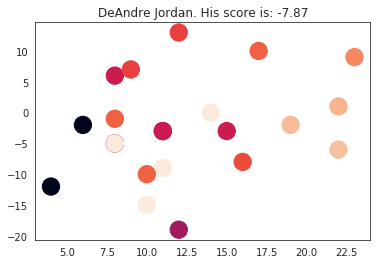

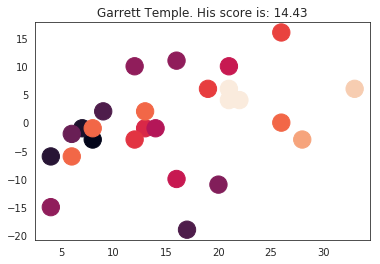

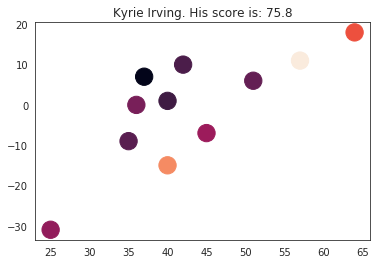

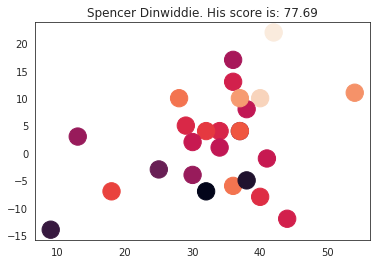

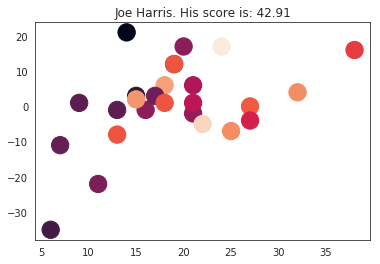

[77.69, 75.8, 42.91, 14.43, -7.87]
Top 5 players on the BKN
0. Spencer Dinwiddie has a stat win index score of: 77.69
1. Kyrie Irving has a stat win index score of: 75.8
2. Joe Harris has a stat win index score of: 42.91
3. Garrett Temple has a stat win index score of: 14.43
4. DeAndre Jordan has a stat win index score of: -7.87


In [178]:
get_winning_stats_per_team("BKN")

['Al Horford' 'Tobias Harris' 'Mike Scott' "Kyle O'Quinn" 'Trey Burke'
 'James Ennis III' 'Raul Neto' 'Norvel Pelle' 'Joel Embiid']


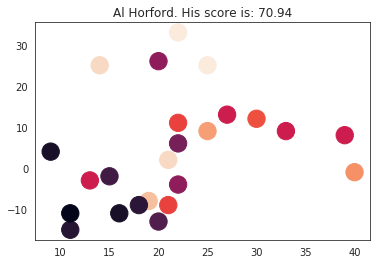

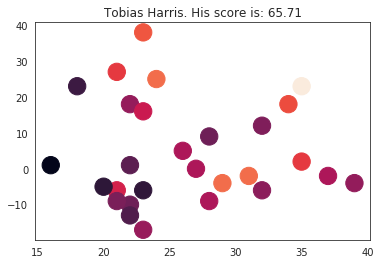

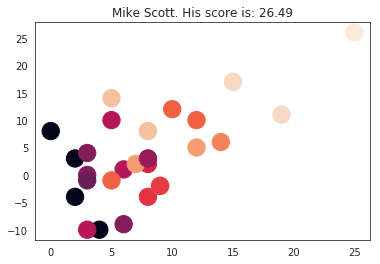

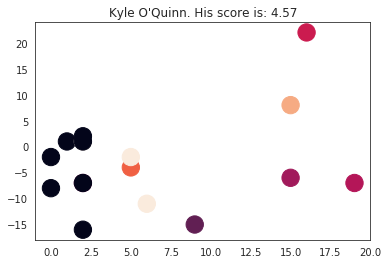

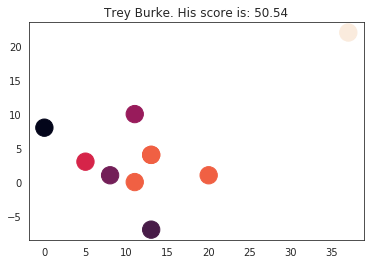

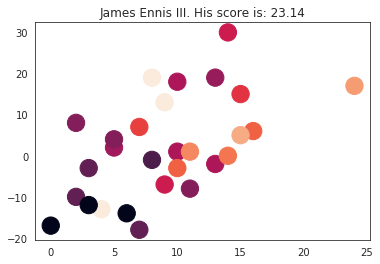

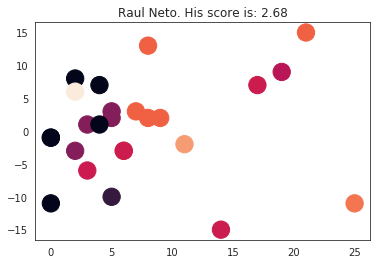

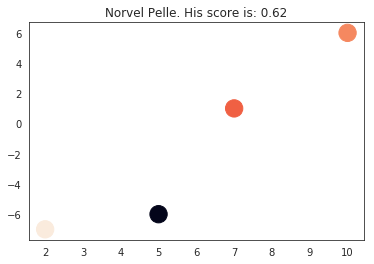

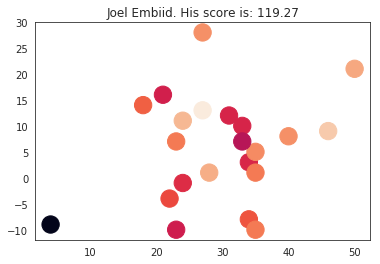

[119.27, 70.94, 65.71, 50.54, 26.49, 23.14, 4.57, 2.68, 0.62]
Top 5 players on the PHI
0. Joel Embiid has a stat win index score of: 119.27
1. Al Horford has a stat win index score of: 70.94
2. Tobias Harris has a stat win index score of: 65.71
3. Trey Burke has a stat win index score of: 50.54
4. Mike Scott has a stat win index score of: 26.49


In [182]:
get_winning_stats_per_team("PHI")

For some reason, there are missing players here need to investigate that LOL

['Kyle Korver' 'Ersan Ilyasova' 'Brook Lopez' 'Robin Lopez' 'George Hill'
 'Wesley Matthews' 'Eric Bledsoe' 'Khris Middleton'
 'Giannis Antetokounmpo' 'Thanasis Antetokounmpo']


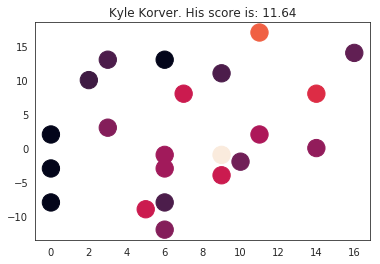

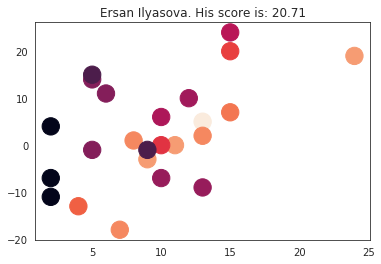

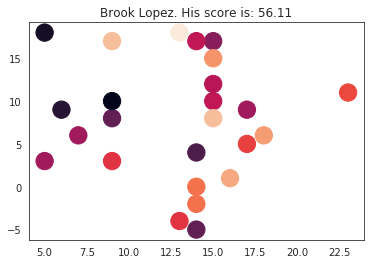

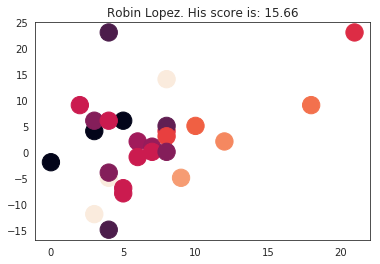

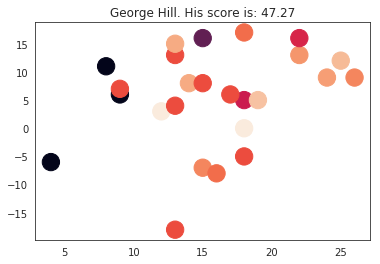

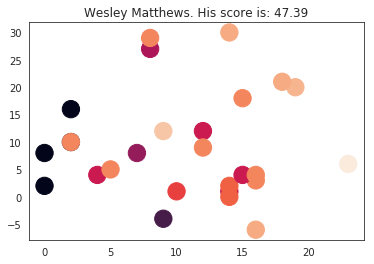

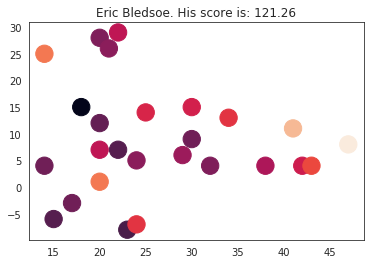

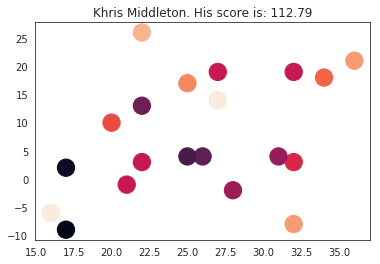

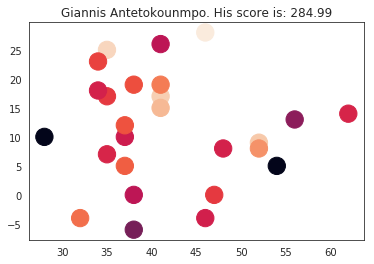

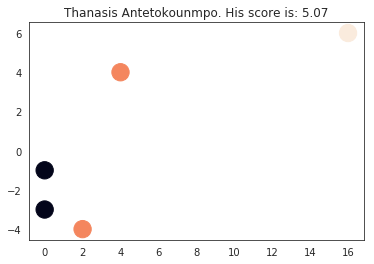

[284.99, 121.26, 112.79, 56.11, 47.39, 47.27, 20.71, 15.66, 11.64, 5.07]
Top 5 players on the MIL
0. Giannis Antetokounmpo has a stat win index score of: 284.99
1. Eric Bledsoe has a stat win index score of: 121.26
2. Khris Middleton has a stat win index score of: 112.79
3. Brook Lopez has a stat win index score of: 56.11
4. Wesley Matthews has a stat win index score of: 47.39


In [183]:
get_winning_stats_per_team("MIL")

['Carmelo Anthony' 'Anthony Tolliver' 'Hassan Whiteside' 'Damian Lillard'
 'Kent Bazemore' 'CJ McCollum' 'Rodney Hood' 'Jusuf Nurkic']


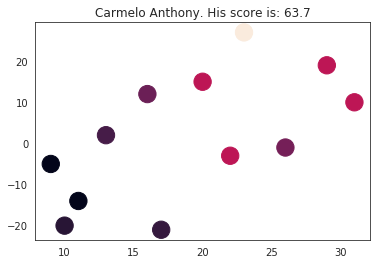

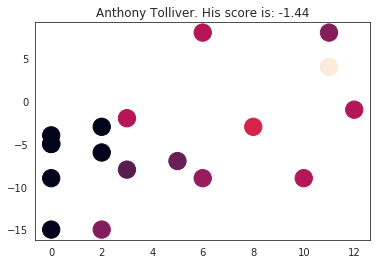

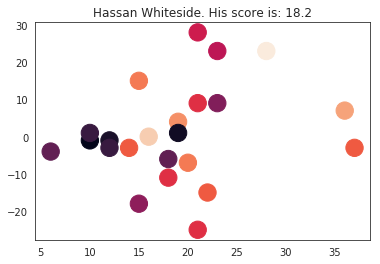

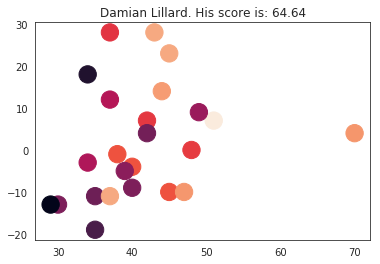

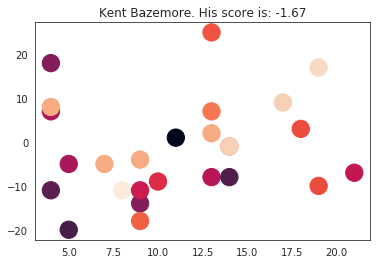

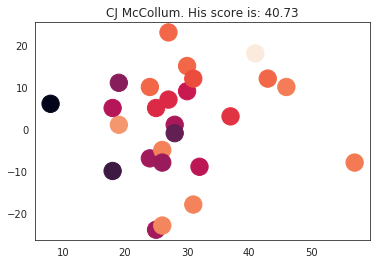

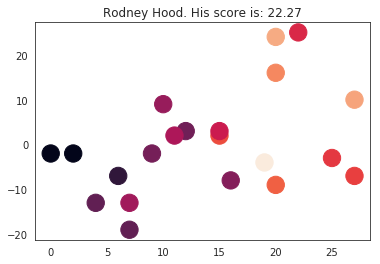

/home/vishnu/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


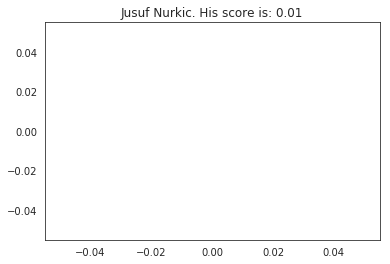

[64.64, 63.7, 40.73, 22.27, 18.2, 0.01, -1.44, -1.67]
Top 5 players on the POR
0. Damian Lillard has a stat win index score of: 64.64
1. Carmelo Anthony has a stat win index score of: 63.7
2. CJ McCollum has a stat win index score of: 40.73
3. Rodney Hood has a stat win index score of: 22.27
4. Hassan Whiteside has a stat win index score of: 18.2


In [184]:
get_winning_stats_per_team("POR")